In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [6]:
warnings.filterwarnings("ignore")

In [2]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2015-01-01',end='2020-12-31')
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1511.0
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.0
std,22.829643,23.042576,22.634188,22.824209,6.771181e+06,0.081388,0.0
min,44.681977,45.383564,41.570073,44.559063,3.324300e+06,0.000000,0.0
25%,56.433754,56.713363,56.017186,56.434137,1.114535e+07,0.000000,0.0
50%,86.894203,88.044232,85.913358,86.872871,1.377760e+07,0.000000,0.0
75%,99.336534,100.329623,98.336740,99.256756,1.772140e+07,0.000000,0.0
max,129.942660,131.580788,129.348221,131.047974,5.619230e+07,0.900000,0.0


In [3]:
# Elimino la colonna 'Stock Splits', poichè è una colonna contenente tutti zeri, è aggiungo la colonna relativa ai rendimenti del titolo
# che serve soltanto per l'analisi esplorativa
JPM = JPM.drop('Stock Splits', axis = 1)
JPM['Rendimenti'] = JPM['Open'].diff()
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Rendimenti
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1510.000000
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.045864
std,22.829643,23.042576,22.634188,22.824209,6.771181e+06,0.081388,1.505812
min,44.681977,45.383564,41.570073,44.559063,3.324300e+06,0.000000,-10.086377
25%,56.433754,56.713363,56.017186,56.434137,1.114535e+07,0.000000,-0.568291
50%,86.894203,88.044232,85.913358,86.872871,1.377760e+07,0.000000,0.064529
75%,99.336534,100.329623,98.336740,99.256756,1.772140e+07,0.000000,0.678116
max,129.942660,131.580788,129.348221,131.047974,5.619230e+07,0.900000,10.493408


ANALISI ESPLORATIVA:


Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura e dei rendimenti del titolo, sia volta a studiare la forza della correlazione serialedi ogni titolo ed eventuale presenza di cointegrazione fra i titoli.

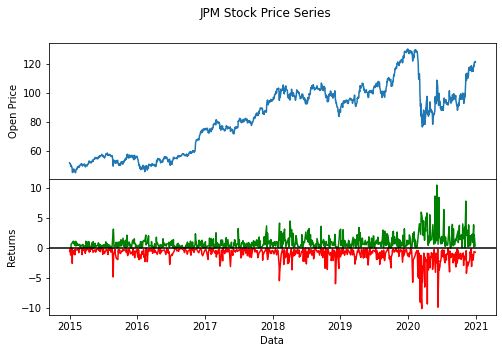

In [4]:
neg = JPM['Rendimenti']>=0
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'][neg==True], color = "green")
axs[1].plot(JPM['Rendimenti'][neg==False], color = "red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()

# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.


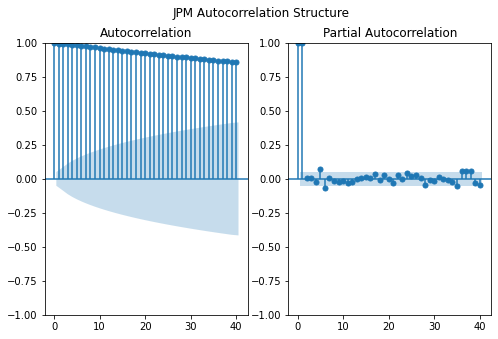

In [7]:
# ACF E PACF della serie; utile anche a capire l'ordine del modello ARIMA
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()

In [9]:
#Test ADF per la verifica dell'ipotesi nulla di radice unitaria
adfTest = adfuller(JPM['Open'], autolag = 'AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
print('Augmented Dickey-Fuller Test Results:\n')
print(dfResults)
# non si rifiuta l'ipotesi nulla di radice unitaria

Augmented Dickey-Fuller Test Results:

ADF Test Statistic       -1.209864
P-Value                   0.669338
# Lags Used               7.000000
# Observations Used    1503.000000
dtype: float64


MODELLAZIONE ARIMA



In [10]:
# creazione del train e del test set

filter_row = JPM.index.to_series().between('2020-01-01', '2020-12-31')
test_set = JPM[filter_row == True]['Open']
training_set = JPM[filter_row==False]['Open']


In [66]:
# definizione dell'ordine del modello arima
print(test_set.shape)
print(range(len(test_set)))


(252,)
range(0, 252)


In [56]:
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [57]:
print(model_fit.summary()) # si rifiuta l'ipotesi nulla di normalità dei residui; il Ljung box è non significativo e quindi il modello filtra la serie
# dalla dipendenza seriale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1510
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2758.981
Date:                Fri, 24 Jun 2022   AIC                           5521.961
Time:                        20:10:29   BIC                           5532.600
Sample:                             0   HQIC                          5525.923
                               - 1510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0251      0.013     -1.908      0.056      -0.051       0.001
sigma2         2.2678      0.034     66.197      0.000       2.201       2.335
Ljung-Box (L1) (Q):                   0.00   Jarque-

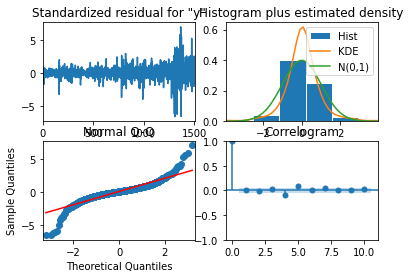

In [58]:
model_fit.plot_diagnostics() # forte asimmetria nella distribuzione dei residui
plt.show()

In [59]:
# valutazione delle previsioni
mse = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse)

Mean Squared Error:	 8.304944178392306


Text(0.5, 1.0, 'ARIMA Predictions')

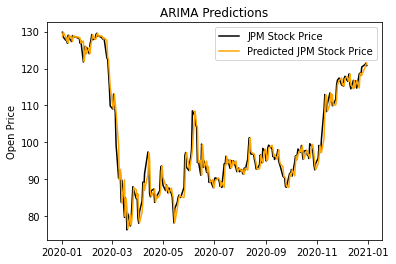

In [60]:
predictions = pd.DataFrame(predictions)
#test_set.index
predictions= predictions.set_index(test_set.index)
plt.plot(test_set, color ="black", label = "JPM Stock Price")
plt.plot(predictions, color="orange", label = "Predicted JPM Stock Price")
plt.legend()
plt.ylabel("Open Price")
plt.title("ARIMA Predictions")

CONVOLUTIONAL NEURAL NETWORK

In [ ]:
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled= mc.fit_transform(training_set[['Open']].values)

In [18]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i:i+temp])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(251, 5, 1)
(251, 5, 1)
(251, 1)


In [ ]:
y_train = np.array(y_train.reshape((-1,1)))
print(y_train)

In [20]:
 # Costruzione del set di test per la multi step walk forward validation, con finestra temporale di 5 giorni
dataset_total = pd.concat((training_set['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(training_set) - len(test_set) - temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(temp, inputs.shape[0]):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(509,)
(509, 1)
(504, 5, 1)


In [45]:
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     #layers.Dropout(0.1),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 59, 64)            192       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1856)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                59424     
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 59,781
Trainable params: 59,781
Non-trainable params: 0
__________________________________________________

In [46]:
batch_size = 4
epochs = 20
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0506 - MSE: 0.0506
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0485 - MSE: 0.0485
Epoch 3/20
300/300 [==============================] - 0s 2ms/step - loss: 0.0482 - MSE: 0.0482
Epoch 4/20
300/300 [==============================] - 0s 2ms/step - loss: 0.0481 - MSE: 0.0481
Epoch 5/20
300/300 [==============================] - 0s 2ms/step - loss: 0.0321 - MSE: 0.0321
Epoch 6/20
300/300 [==============================] - 0s 2ms/step - loss: 9.5048e-04 - MSE: 9.5048e-04
Epoch 7/20
300/300 [==============================] - 0s 2ms/step - loss: 0.0011 - MSE: 0.0011
Epoch 8/20
300/300 [==============================] - 0s 2ms/step - loss: 8.3706e-04 - MSE: 8.3706e-04
Epoch 9/20
300/300 [==============================] - 0s 2ms/step - loss: 8.5194e-04 - MSE: 8.5194e-04
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 7.5833e-04 - MSE: 7.5833e-04
Epoch 11/20
300/3

In [49]:
test_set['Open']
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
#predicted_stock_price = np.reshape(predicted_stock_price, (564,1))
#test_set['predicted_stock_price'] = predicted_stock_price
print(predicted_stock_price.shape)


ValueError: cannot reshape array of size 2520 into shape (564,1)

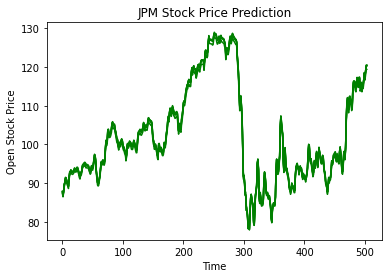

In [35]:
# previsioni del titolo
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
#plt.plot(test_set['Open'], color = 'black', label = 'JPM Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted jpm Stock Price - 5 days')
plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Open Stock Price')
#plt.legend()
plt.show()

In [69]:
# usiamo una finestra temporale di due settimane
X_train = []
y_train = []
temp = 10
for i in range(temp, training_set.shape[0]):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
dataset_total = pd.concat((training_set['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(training_set) - len(test_set) - temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(temp, inputs.shape[0]):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(516,)
(506, 10, 1)


In [73]:
model_10_CNN = keras.Sequential(
    [
     keras.Input(shape=(10,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     #layers.Dropout(0.1),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(10, activation = "relu")
    ]
)
model_10_CNN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 9, 64)             192       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                8224      
                                                                 
 dense_19 (Dense)            (None, 10)                330       
                                                                 
Total params: 8,746
Trainable params: 8,746
Non-trainable params: 0
____________________________________________________

In [74]:
batch_size = 4
epochs = 20
model_10_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_10_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
312/312 [==============================] - 1s 1ms/step - loss: 0.0496 - MSE: 0.0496
Epoch 2/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 3/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 4/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 5/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 6/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 7/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 8/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 9/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 10/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 11/20
312/312 [============================

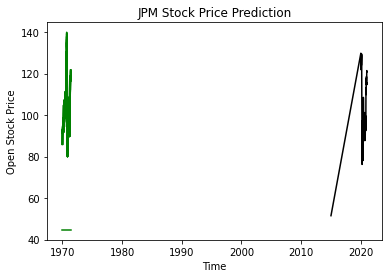

In [75]:
# previsioni del titolo
predicted_stock_price = model_10_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
plt.plot(test_set['Open'], color = 'black', label = 'JPM Stock Price')
#plt.plot(predicted_stock_price, color = 'green', label = 'Predicted jpm Stock Price - 5 days')
plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Open Stock Price')
#plt.legend()
plt.show()

In [76]:
predicted_stock_price

array([[ 85.98212 ,  86.31778 ,  44.681965, ...,  85.959114,  85.85162 ,
         86.06537 ],
       [ 88.20231 ,  88.18235 ,  44.681965, ...,  88.02045 ,  87.9476  ,
         87.94542 ],
       [ 89.1346  ,  88.84079 ,  44.681965, ...,  88.990524,  88.71934 ,
         88.61677 ],
       ...,
       [119.49258 , 119.40489 ,  44.681965, ..., 119.31537 , 119.10601 ,
        119.47016 ],
       [120.624   , 120.80585 ,  44.681965, ..., 120.31091 , 120.41752 ,
        120.87492 ],
       [121.513176, 121.64355 ,  44.681965, ..., 121.28423 , 121.42618 ,
        121.865616]], dtype=float32)

RETE RICORRENTE

In [ ]:
model_RNN = keras.Sequential(
    [
        keras.Input()
    ]
)